# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
'''
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]
'''


learning_rates =[5e-9, 7.5e-9, 1e-8]
regularization_strengths = [(5+i)*1e6 for i in range(-3,4)]


results = {}
best_val = -1
best_svm = None
from tqdm import tqdm, trange
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for rates in tqdm(learning_rates):
    for strengths in tqdm(regularization_strengths):
        tmp_svm = LinearSVM()
        tmp_svm.train(X_train_feats,y_train,learning_rate = rates,reg = strengths,num_iters = 1500,batch_size = 200,verbose=True)
        train_acc = np.mean(tmp_svm.predict(X_train_feats)==y_train)
        val_acc = np.mean(tmp_svm.predict(X_val_feats)==y_val)
        if best_val<val_acc:
            best_svm = tmp_svm
            best_val = val_acc

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)



  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/7 [00:00<?, ?it/s]

iteration 0 / 1500: loss 3266.895040
iteration 100 / 1500: loss 445.497804
iteration 200 / 1500: loss 67.479784
iteration 300 / 1500: loss 16.835647
iteration 400 / 1500: loss 10.049860
iteration 500 / 1500: loss 9.140548
iteration 600 / 1500: loss 9.018848
iteration 700 / 1500: loss 9.002525
iteration 800 / 1500: loss 9.000336
iteration 900 / 1500: loss 9.000039
iteration 1000 / 1500: loss 9.000005
iteration 1100 / 1500: loss 9.000003
iteration 1200 / 1500: loss 9.000005
iteration 1300 / 1500: loss 8.999998
iteration 1400 / 1500: loss 9.000003





 14%|█▍        | 1/7 [01:08<06:51, 68.64s/it]

iteration 0 / 1500: loss 4612.689346
iteration 100 / 1500: loss 233.052893
iteration 200 / 1500: loss 19.904427
iteration 300 / 1500: loss 9.530656
iteration 400 / 1500: loss 9.025792
iteration 500 / 1500: loss 9.001252
iteration 600 / 1500: loss 9.000059
iteration 700 / 1500: loss 9.000007
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000001
iteration 1200 / 1500: loss 8.999999
iteration 1300 / 1500: loss 9.000002
iteration 1400 / 1500: loss 9.000001





 29%|██▊       | 2/7 [02:16<05:42, 68.47s/it]

iteration 0 / 1500: loss 6257.038617
iteration 100 / 1500: loss 118.888875
iteration 200 / 1500: loss 10.932652
iteration 300 / 1500: loss 9.033960
iteration 400 / 1500: loss 9.000594
iteration 500 / 1500: loss 9.000009
iteration 600 / 1500: loss 9.000001
iteration 700 / 1500: loss 8.999999
iteration 800 / 1500: loss 8.999998
iteration 900 / 1500: loss 8.999999
iteration 1000 / 1500: loss 8.999998
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000001
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 8.999999





 43%|████▎     | 3/7 [03:30<04:40, 70.02s/it]

iteration 0 / 1500: loss 7743.467283
iteration 100 / 1500: loss 57.904213
iteration 200 / 1500: loss 9.309216
iteration 300 / 1500: loss 9.001951
iteration 400 / 1500: loss 9.000013
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000001
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 9.000002
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000000





 57%|█████▋    | 4/7 [04:36<03:26, 68.95s/it]

iteration 0 / 1500: loss 9082.732516
iteration 100 / 1500: loss 29.517073
iteration 200 / 1500: loss 9.046412
iteration 300 / 1500: loss 9.000105
iteration 400 / 1500: loss 8.999999
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 8.999999
iteration 800 / 1500: loss 9.000002
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000001
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 8.999999





 71%|███████▏  | 5/7 [06:08<02:31, 75.68s/it]

iteration 0 / 1500: loss 9892.753423
iteration 100 / 1500: loss 16.950879
iteration 200 / 1500: loss 9.006405
iteration 300 / 1500: loss 9.000005
iteration 400 / 1500: loss 8.999999
iteration 500 / 1500: loss 8.999999
iteration 600 / 1500: loss 9.000001
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 8.999999
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000001
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000001





 86%|████████▌ | 6/7 [07:29<01:17, 77.22s/it]

iteration 0 / 1500: loss 11682.074592
iteration 100 / 1500: loss 12.322492
iteration 200 / 1500: loss 9.000947
iteration 300 / 1500: loss 9.000001
iteration 400 / 1500: loss 9.000000
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 8.999999





100%|██████████| 7/7 [08:45<00:00, 77.03s/it]

 33%|███▎      | 1/3 [08:45<17:31, 525.65s/it]


  0%|          | 0/7 [00:00<?, ?it/s]

iteration 0 / 1500: loss 3302.242536
iteration 100 / 1500: loss 169.271644
iteration 200 / 1500: loss 16.799924
iteration 300 / 1500: loss 9.379526
iteration 400 / 1500: loss 9.018437
iteration 500 / 1500: loss 9.000894
iteration 600 / 1500: loss 9.000039
iteration 700 / 1500: loss 9.000003
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 8.999999
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 9.000002
iteration 1200 / 1500: loss 8.999998
iteration 1300 / 1500: loss 9.000004
iteration 1400 / 1500: loss 9.000002





 14%|█▍        | 1/7 [01:14<07:28, 74.74s/it]

iteration 0 / 1500: loss 4705.983154
iteration 100 / 1500: loss 58.565380
iteration 200 / 1500: loss 9.523048
iteration 300 / 1500: loss 9.005534
iteration 400 / 1500: loss 9.000058
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000004
iteration 700 / 1500: loss 9.000001
iteration 800 / 1500: loss 8.999999
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 8.999999
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 8.999998
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000000





 29%|██▊       | 2/7 [02:27<06:11, 74.25s/it]

iteration 0 / 1500: loss 6046.371125
iteration 100 / 1500: loss 22.651748
iteration 200 / 1500: loss 9.030886
iteration 300 / 1500: loss 9.000069
iteration 400 / 1500: loss 9.000000
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 8.999999
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000002





 43%|████▎     | 3/7 [03:30<04:43, 70.87s/it]

iteration 0 / 1500: loss 7854.123920
iteration 100 / 1500: loss 12.755713
iteration 200 / 1500: loss 9.001798
iteration 300 / 1500: loss 9.000001
iteration 400 / 1500: loss 9.000001
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 8.999999
iteration 1200 / 1500: loss 8.999999
iteration 1300 / 1500: loss 8.999999
iteration 1400 / 1500: loss 9.000000





 57%|█████▋    | 4/7 [04:35<03:27, 69.16s/it]

iteration 0 / 1500: loss 9334.132467
iteration 100 / 1500: loss 9.934167
iteration 200 / 1500: loss 9.000094
iteration 300 / 1500: loss 9.000001
iteration 400 / 1500: loss 8.999998
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 9.000001





 71%|███████▏  | 5/7 [05:33<02:11, 65.75s/it]

iteration 0 / 1500: loss 10564.103995
iteration 100 / 1500: loss 9.218501
iteration 200 / 1500: loss 9.000004
iteration 300 / 1500: loss 9.000001
iteration 400 / 1500: loss 9.000001
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000001
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 8.999999
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000001
iteration 1200 / 1500: loss 9.000001
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 9.000001





 86%|████████▌ | 6/7 [06:40<01:05, 65.98s/it]

iteration 0 / 1500: loss 13518.531917
iteration 100 / 1500: loss 9.057009
iteration 200 / 1500: loss 9.000001
iteration 300 / 1500: loss 9.000001
iteration 400 / 1500: loss 9.000001
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000001
iteration 700 / 1500: loss 9.000001
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000000





100%|██████████| 7/7 [08:06<00:00, 72.04s/it]

 67%|██████▋   | 2/3 [16:52<08:33, 513.93s/it]


  0%|          | 0/7 [00:00<?, ?it/s]

iteration 0 / 1500: loss 3209.231847
iteration 100 / 1500: loss 65.282959
iteration 200 / 1500: loss 9.989654
iteration 300 / 1500: loss 9.017374
iteration 400 / 1500: loss 9.000306
iteration 500 / 1500: loss 9.000004
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 8.999998
iteration 800 / 1500: loss 8.999999
iteration 900 / 1500: loss 8.999997
iteration 1000 / 1500: loss 8.999998
iteration 1100 / 1500: loss 9.000004
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000002
iteration 1400 / 1500: loss 8.999998





 14%|█▍        | 1/7 [01:34<09:24, 94.04s/it]

iteration 0 / 1500: loss 4219.296062
iteration 100 / 1500: loss 18.520063
iteration 200 / 1500: loss 9.021529
iteration 300 / 1500: loss 9.000049
iteration 400 / 1500: loss 9.000000
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000001
iteration 700 / 1500: loss 9.000001
iteration 800 / 1500: loss 9.000002
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000002
iteration 1100 / 1500: loss 9.000001
iteration 1200 / 1500: loss 9.000001
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 9.000000





 29%|██▊       | 2/7 [02:44<07:14, 86.86s/it]

iteration 0 / 1500: loss 6509.072518
iteration 100 / 1500: loss 10.850111
iteration 200 / 1500: loss 9.000531
iteration 300 / 1500: loss 9.000000
iteration 400 / 1500: loss 8.999998
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 8.999998
iteration 800 / 1500: loss 9.000000
iteration 900 / 1500: loss 8.999998
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000000





 43%|████▎     | 3/7 [03:54<05:27, 82.00s/it]

iteration 0 / 1500: loss 7705.214278
iteration 100 / 1500: loss 9.269823
iteration 200 / 1500: loss 9.000010
iteration 300 / 1500: loss 9.000000
iteration 400 / 1500: loss 8.999999
iteration 500 / 1500: loss 8.999999
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 8.999999
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 8.999998
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 9.000000





 57%|█████▋    | 4/7 [04:59<03:50, 76.70s/it]

iteration 0 / 1500: loss 9314.605250
iteration 100 / 1500: loss 9.039236
iteration 200 / 1500: loss 9.000000
iteration 300 / 1500: loss 9.000000
iteration 400 / 1500: loss 9.000000
iteration 500 / 1500: loss 9.000001
iteration 600 / 1500: loss 9.000001
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 8.999999
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 8.999999
iteration 1200 / 1500: loss 8.999999
iteration 1300 / 1500: loss 9.000001
iteration 1400 / 1500: loss 8.999999





 71%|███████▏  | 5/7 [06:14<02:32, 76.22s/it]

iteration 0 / 1500: loss 10814.058676
iteration 100 / 1500: loss 9.005358
iteration 200 / 1500: loss 9.000001
iteration 300 / 1500: loss 9.000000
iteration 400 / 1500: loss 9.000001
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 9.000001
iteration 1000 / 1500: loss 9.000001
iteration 1100 / 1500: loss 8.999999
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 9.000000
iteration 1400 / 1500: loss 9.000001





 86%|████████▌ | 6/7 [07:18<01:12, 72.53s/it]

iteration 0 / 1500: loss 13013.138840
iteration 100 / 1500: loss 9.000740
iteration 200 / 1500: loss 9.000001
iteration 300 / 1500: loss 9.000000
iteration 400 / 1500: loss 9.000000
iteration 500 / 1500: loss 9.000000
iteration 600 / 1500: loss 9.000000
iteration 700 / 1500: loss 9.000000
iteration 800 / 1500: loss 9.000001
iteration 900 / 1500: loss 9.000000
iteration 1000 / 1500: loss 9.000000
iteration 1100 / 1500: loss 9.000000
iteration 1200 / 1500: loss 9.000000
iteration 1300 / 1500: loss 8.999999
iteration 1400 / 1500: loss 9.000001





100%|██████████| 7/7 [08:37<00:00, 74.70s/it]

100%|██████████| 3/3 [25:30<00:00, 515.15s/it]

best validation accuracy achieved during cross-validation: 0.014000


In [15]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.007


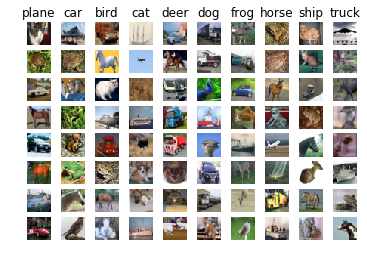

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [16]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1
learning_rates = [1e-2 ,1e-1, 5e-1, 1, 5]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]

for rates in tqdm(learning_rates):
    for strengths in tqdm(regularization_strengths):
        net.train(X_train_feats,y_train,X_val_feats,y_val,learning_rate = rates,reg = strengths,num_iters = 1500)
        train_acc = np.mean(net.predict(X_train_feats) == y_train)
        val_acc = np.mean(net.predict(X_val_feats) == y_val)
        if val_acc > best_val:
            print("val acc now is ",val_acc)
            best_val = val_acc 
            best_net = net
        results[(rates,strengths)] = train_acc ,val_acc
for rates ,strengths in sorted(results):
    train_acc ,val_acc = results[(rates,strengths)]
    print("train_acc is {} , val acc is {}".format(train_acc,val_acc))
print("best result is",best_val)





  0%|          | 0/5 [00:00<?, ?it/s]




  0%|          | 0/6 [00:00<?, ?it/s]




 17%|█▋        | 1/6 [00:57<04:49, 57.81s/it]

val acc now is  0.126







 33%|███▎      | 2/6 [01:49<03:43, 55.86s/it]

val acc now is  0.296







 50%|█████     | 3/6 [03:09<03:09, 63.15s/it]

val acc now is  0.397







 67%|██████▋   | 4/6 [04:31<02:17, 68.73s/it]

val acc now is  0.418







 83%|████████▎ | 5/6 [05:31<01:06, 66.22s/it]




100%|██████████| 6/6 [06:28<00:00, 63.47s/it]



 20%|██        | 1/5 [06:28<25:53, 388.49s/it]




  0%|          | 0/6 [00:00<?, ?it/s]




 17%|█▋        | 1/6 [01:07<05:35, 67.04s/it]

val acc now is  0.511







 33%|███▎      | 2/6 [02:04<04:16, 64.15s/it]

val acc now is  0.543







 50%|█████     | 3/6 [02:55<03:00, 60.24s/it]




 67%|██████▋   | 4/6 [03:38<01:50, 55.18s/it]




 83%|████████▎ | 5/6 [04:17<00:50, 50.08s/it]




100%|██████████| 6/6 [05:03<00:00, 48.96s/it]



 40%|████      | 2/5 [11:32<18:09, 363.02s/it]




  0%|          | 0/6 [00:00<?, ?it/s]




 17%|█▋        | 1/6 [01:12<06:04, 72.84s/it]

val acc now is  0.584







 33%|███▎      | 2/6 [02:26<04:52, 73.10s/it]




 50%|█████     | 3/6 [03:12<03:14, 64.88s/it]




 67%|██████▋   | 4/6 [03:55<01:56, 58.44s/it]




 83%|████████▎ | 5/6 [04:39<00:54, 54.01s/it]




100%|██████████| 6/6 [05:34<00:00, 54.49s/it]



 60%|██████    | 3/5 [17:07<11:49, 354.63s/it]




  0%|          | 0/6 [00:00<?, ?it/s]




 17%|█▋        | 1/6 [01:09<05:46, 69.40s/it]




 33%|███▎      | 2/6 [02:02<04:18, 64.60s/it]




 50%|█████     | 3/6 [03:04<03:11, 63.75s/it]




 67%|██████▋   | 4/6 [04:00<02:03, 61.55s/it]




 83%|████████▎ | 5/6 [04:46<00:56, 56.70s/it]




100%|██████████| 6/6 [05:36<00:00, 54.64s/it]



 80%|████████  | 4/5 [22:43<05:49, 349.13s/it]




  0%|          | 0/6 [00:00<?, ?it/s]/home/li/ML/CS231N/assignment1/cs231n/classifiers/neural_net.py:100: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(Smax_loss[range(N),list(y)]))/N+0.5*reg*(np.sum(W1*W1)+np.sum(W2*W2))





 17%|█▋        | 1/6 [00:51<04:15, 51.00s/it]




train_acc is 0.1456734693877551 , val acc is 0.126
train_acc is 0.28155102040816327 , val acc is 0.296
train_acc is 0.41185714285714287 , val acc is 0.397
train_acc is 0.4323877551020408 , val acc is 0.418
train_acc is 0.22110204081632653 , val acc is 0.212
train_acc is 0.10044897959183674 , val acc is 0.078
train_acc is 0.5205102040816326 , val acc is 0.511
train_acc is 0.5578163265306122 , val acc is 0.543
train_acc is 0.5660408163265306 , val acc is 0.542
train_acc is 0.4463673469387755 , val acc is 0.437
train_acc is 0.15977551020408162 , val acc is 0.186
train_acc is 0.09961224489795918 , val acc is 0.119
train_acc is 0.6388775510204082 , val acc is 0.584
train_acc is 0.6373469387755102 , val acc is 0.582
train_acc is 0.5820408163265306 , val acc is 0.555
train_acc is 0.4103673469387755 , val acc is 0.39
train_acc is 0.17324489795918369 , val acc is 0.147
train_acc is 0.10004081632653061 , val acc is 0.098
train_acc is 0.6627755102040817 , val acc is 0.575
train_acc is 0.609693877

In [20]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.103
